## Modeling multiple warping functions per trial

Here is some proof-of-principle code that fits the following model:

$$
\mathbf{X}_k \approx \sum_{p=1}^P \mathbf{W}_{k, p} ~ \widehat{\mathbf{X}}_{p}
$$

where $\mathbf{X}_k$ is a `num_timepoints x num_units` matrix holding data on trial $k$. The model optimizes $P$ different template matrices, denoted $\widehat{\mathbf{X}}_{p}$, as well as per-trial warping functions $\mathbf{W}_{k, p}$ for each template. For now we are restricted to the case where $\mathbf{W}_{k, p}$ encodes a shift / temporal translation.

Here we simulate data from two populations of neurons that are independently time warped. The `MultiShiftWarp` model closely identifies the ground truth in this case.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Generate some synthetic data

In [2]:
from affinewarp.datasets import piecewise_warped_data

data_options = dict(
    n_knots=-1,
    n_trials=100,
    n_timepoints=150,
    n_neurons=30,
    clip_y_knots=False,
    template_scale=1.0,
    template_drop=.9,
    template_smoothness=2,
    knot_mutation_scale=.2,
    noise_type="poisson",
)

binned_1, true_model_1 = piecewise_warped_data(seed=3, **data_options)
binned_2, true_model_2 = piecewise_warped_data(seed=4, **data_options)

true_model_1.template[:, ::2] *= 0
binned_1[:, :, ::2] *= 0

true_model_2.template[:, 1::2] *= 0
binned_2[:, :, 1::2] *= 0

### Fit the model

In [3]:
from affinewarp.multiwarp import MultiShiftWarping

np.random.seed(123)
model = MultiShiftWarping(n_templates=2, maxlag=.3, nonneg=True, center_shifts=True, smoothness_reg_scale=0.1)
binned = binned_1 + binned_2
model.fit(binned, iterations=50)

100%|██████████| 50/50 [00:04<00:00, 12.46it/s]


### Optimization learning curve

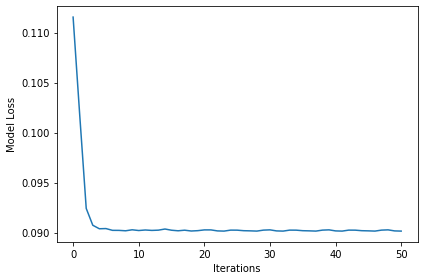

In [4]:
plt.plot(model.loss_hist)
plt.ylabel("Model Loss")
plt.xlabel("Iterations")
plt.tight_layout()

### Plot ground truth template matrices against model estimates

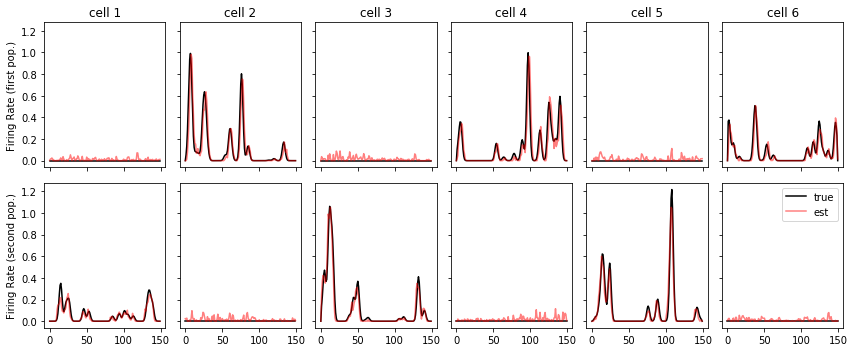

In [5]:
# Compare true template to estimated template across some neurons
fig, axes = plt.subplots(2, 6, sharex=True, sharey=True, figsize=(12, 5))

for i, ax in enumerate(axes[0]):
    ax.plot(true_model_1.template[:, i], color='k', label='true')
    ax.plot(model.models[1].template[:, i], color='r', alpha=.5, label='est')
    ax.set_title("cell {}".format(i + 1))

for i, ax in enumerate(axes[1]):
    ax.plot(true_model_2.template[:, i], color='k', label='true')
    ax.plot(model.models[0].template[:, i], color='r', alpha=.5, label='est')

axes[-1, -1].legend()
axes[0, 0].set_ylabel("Firing Rate (first pop.)")
axes[1, 0].set_ylabel("Firing Rate (second pop.)")
fig.tight_layout()

### Plot ground truth shifts vs. model estimates.

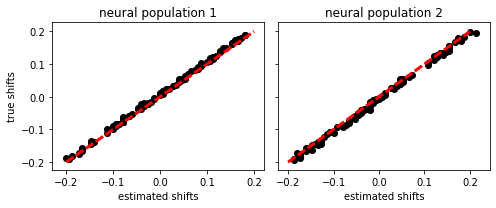

In [6]:
true_shifts = [
    -true_model_1.y_knots[:, 0],
    -true_model_2.y_knots[:, 0],
]
est_shifts = [
    model.models[1].shifts / data_options['n_timepoints'],
    model.models[0].shifts / data_options['n_timepoints'],
]


fig, axes = plt.subplots(1, 2, sharey=True, figsize=(7, 3))

for s, ax in enumerate(axes):
    ax.plot([-.2, .2], [-.2, .2], 'r', lw=3, dashes=[3, 1])
    ax.scatter(est_shifts[s], true_shifts[s], color='k', lw=0, s=50)
    ax.set_xlabel("estimated shifts")
    ax.set_title("neural population {}".format(s + 1))

axes[0].set_ylabel("true shifts")

fig.tight_layout()